In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from google.colab import drive
from wordcloud import WordCloud
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import beta
from collections import Counter
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
news_df=pd.read_csv('/content/drive/MyDrive/news.tsv',header=None,sep='\t')
news_df.columns=['News ID',
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities",
"Abstract Entities "]
behaviours_df = pd.read_csv("/content/drive/MyDrive/behaviors.tsv",sep="\t",names=["impressionId","userId","timestamp","click_history","impressions"])

In [ ]:
unique_user_count = behaviours_df['userId'].nunique()

print("Number of unique user IDs:", unique_user_count)


Number of unique user IDs: 50000


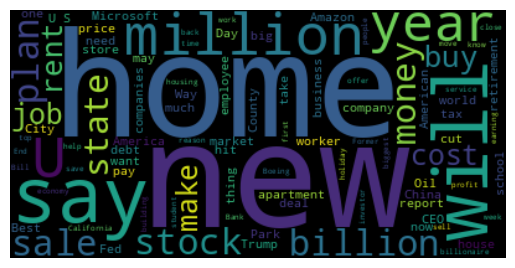

In [ ]:

text=' '
for i in news_df[news_df['Category']=='finance']['Title']:
    text+=i+' '

wordcloud = WordCloud().generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

In [ ]:
news_id_to_title = news_df.set_index('News ID')['Title'].to_dict()
news_category_mapping = news_df.set_index('News ID')['Category'].to_dict()
user_click_history = {}
for index, row in behaviours_df.iterrows():
    user_id = row['userId']
    clicked_articles = str(row['click_history']).split()
    clicked_articles = [article for article in clicked_articles if article.lower() != 'nan']
    user_click_history.setdefault(user_id, set()).update(clicked_articles)

In [ ]:
categories = news_df['Category'].unique()

In [ ]:
def initialize_parameters(user_click_history, news_category_mapping):
    user_category_counts = {}
    for user_id, clicked_news_ids in user_click_history.items():
        user_category_counts[user_id] = {category: 1 for category in categories}
        for news_id in clicked_news_ids:
            if news_id in news_category_mapping:
                category = news_category_mapping[news_id]
                user_category_counts[user_id][category] += 1
    user_alpha_beta_params = {
        user_id: {category: [count, 1] for category, count in category_counts.items()}
        for user_id, category_counts in user_category_counts.items()
    }
    return user_alpha_beta_params

In [ ]:
user_alpha_beta_params = initialize_parameters(user_click_history, news_category_mapping)

In [ ]:
def recommend_article(user_id, user_alpha_beta_params, news_df, news_category_mapping):
    sampled_probs = {
        category: np.random.beta(a=user_alpha_beta_params[user_id][category][0], b=user_alpha_beta_params[user_id][category][1])
        for category in user_alpha_beta_params[user_id].keys()
    }
    chosen_category = max(sampled_probs, key=sampled_probs.get)
    possible_articles = news_df[news_df['Category'] == chosen_category]
    if not possible_articles.empty:
        recommended_article = possible_articles.sample(1).iloc[0]
        return recommended_article['News ID']
    return None


In [ ]:
def get_most_viewed_categories(user_id, user_alpha_beta_params):
    category_clicks = {category: params[0] - 1 for category, params in user_alpha_beta_params[user_id].items()}  # Subtract 1 for the initial value
    sorted_categories = sorted(category_clicks.items(), key=lambda item: item[1], reverse=True)
    return sorted_categories

In [ ]:
def recommend_and_display_article(user_id, user_alpha_beta_params,news_df,news_category_mapping):
    most_viewed_categories = get_most_viewed_categories(user_id, user_alpha_beta_params)
    print(f"User's most viewed categories: {most_viewed_categories}")
    recommended_news_id = recommend_article(user_id, user_alpha_beta_params,news_df,news_category_mapping)
    if recommended_news_id:
        news_title = news_id_to_title[recommended_news_id]
        news_category = news_category_mapping[recommended_news_id]
        print(f"Recommended Article: {recommended_news_id} - {news_title} (Category: {news_category})")
    else:
        print("No article recommended.")
    return recommended_news_id

In [ ]:
def simulate_user_interaction_and_update(user_id, news_id,user_alpha_beta_params):
    user_clicks = np.random.rand() < 0.5
    category = news_category_mapping[news_id]
    user_alpha_beta_params[user_id][category][0] += user_clicks
    user_alpha_beta_params[user_id][category][1] += (1 - user_clicks)

    return user_clicks

In [ ]:
def update_user_click_history(user_id, news_id, user_click_history, behaviours_df):
    if user_id not in user_click_history:
        user_click_history[user_id] = set()
    user_click_history[user_id].add(news_id)

    if user_id in behaviours_df['userId'].values:
        current_history = behaviours_df.loc[behaviours_df['userId'] == user_id, 'click_history'].iloc[0]
        current_history = '' if pd.isna(current_history) else str(current_history)
        updated_history = current_history + ' ' + news_id if current_history else news_id
        behaviours_df.loc[behaviours_df['userId'] == user_id, 'click_history'] = updated_history
    else:
        new_entry = pd.DataFrame({
            'userId': [user_id],
            'click_history': [news_id],
            'Impressions': ['']
        })
        behaviours_df = pd.concat([behaviours_df, new_entry], ignore_index=True)

    return behaviours_df


In [ ]:
user_id = 'U91836'
user_alpha_beta_params = initialize_parameters(user_click_history, news_category_mapping)
recommended_news_id = recommend_and_display_article(user_id, user_alpha_beta_params, news_df, news_category_mapping)

if recommended_news_id:
    user_clicked = simulate_user_interaction_and_update(user_id, recommended_news_id, user_alpha_beta_params)
    click_status = 'clicked' if user_clicked else 'not clicked'
    if click_status=='clicked':
      update_user_click_history(user_id, recommended_news_id, user_click_history,behaviours_df)
    print(f"User {click_status} on the recommended article.")


User's most viewed categories: [('news', 54), ('lifestyle', 5), ('travel', 5), ('finance', 5), ('sports', 3), ('foodanddrink', 3), ('weather', 2), ('health', 1), ('movies', 1), ('video', 1), ('music', 1), ('entertainment', 0), ('autos', 0), ('tv', 0), ('kids', 0), ('middleeast', 0), ('northamerica', 0)]
Recommended Article: N60747 - Emails Outline Anti-Immigration Group's Connection to Stephen Miller (Category: news)
User clicked on the recommended article.


In [ ]:
category_counts = {category: 0 for category in categories}
def recommend_top_articles(user_id, user_alpha_beta_params, news_df):
    sampled_probs = {
        category: np.random.beta(a=user_alpha_beta_params[user_id][category][0], b=user_alpha_beta_params[user_id][category][1])
        for category in user_alpha_beta_params[user_id].keys()
    }
    adjusted_preferences = {
            category: pref + np.sqrt((2 * np.log(sum(category_counts.values()) + 1)) / (category_counts[category] + 1))
            for category, pref in sampled_probs.items()
        }
    top_categories = sorted(adjusted_preferences, key=adjusted_preferences.get, reverse=True)[:3]
    sorted_categories = sorted(sampled_probs.items(), key=lambda item: item[1], reverse=True)
    top_categories = [cat[0] for cat in sorted_categories[:3]]  # Top 3 categories
    top_articles = []
    for category in top_categories:
        category_articles = news_df[news_df['Category'] == category]
        sampled_articles = category_articles.sample(min(5, len(category_articles)))  # Sample up to 5 articles
        top_articles.extend(sampled_articles.to_dict('records'))
    np.random.shuffle(top_articles)
    return top_articles[:5]




In [ ]:
def reinitialize_parameters(user_click_history, news_category_mapping, categories):
    user_category_counts = {}
    for user_id, clicked_news_ids in user_click_history.items():
        category_counts = {category: 1 for category in categories}
        for news_id in clicked_news_ids:
            if news_id in news_category_mapping:
                category = news_category_mapping[news_id]
                category_counts[category] += 1
        user_category_counts[user_id] = category_counts
    user_alpha_beta_params = {
        user_id: {category: [count, 1] for category, count in counts.items()}  # Beta remains 1 as uniform prior
        for user_id, counts in user_category_counts.items()
    }
    return user_alpha_beta_params


In [ ]:
recommended_articles = recommend_top_articles(user_id, user_alpha_beta_params, news_df)

print(f"User's most viewed categories: {get_most_viewed_categories(user_id, user_alpha_beta_params)}")

for article in recommended_articles:
    print(f"Recommended Article: {article['News ID']} - {article['Title']} (Category: {article['Category']})")
    user_clicked = np.random.rand() < 0.5
    click_status = 'clicked' if user_clicked else 'not clicked'
    user_alpha_beta_params = reinitialize_parameters(user_click_history, news_category_mapping, categories)
    if click_status == 'clicked':
        behaviours_df = update_user_click_history(user_id, article['News ID'], user_click_history, behaviours_df)
    print(f"User {click_status} on the recommended article.")


User's most viewed categories: [('news', 55), ('finance', 6), ('lifestyle', 5), ('travel', 5), ('sports', 3), ('foodanddrink', 3), ('weather', 2), ('video', 2), ('health', 1), ('movies', 1), ('music', 1), ('entertainment', 0), ('autos', 0), ('tv', 0), ('kids', 0), ('middleeast', 0), ('northamerica', 0)]
Recommended Article: N60470 - Trailer - The King's Man (Category: movies)
User not clicked on the recommended article.
Recommended Article: N57472 - 5 films to see during the The Gershman Philadelphia Jewish Film Festival (Category: movies)
User clicked on the recommended article.
Recommended Article: N6836 - Search for missing teen in Statesville (Category: news)
User not clicked on the recommended article.
Recommended Article: N626 - Fire Crews Knock Down Brush Fire Near Route 242 In Concord (Category: weather)
User clicked on the recommended article.
Recommended Article: N46879 - Father of 9-Year-Old With Autism Who Drowned in September Believes DCFS Was 'Negligent' (Category: news)


In [ ]:

def get_top_categories(user_id, behaviors, news_df, top_n=5):
    click_history = behaviors.loc[behaviors['userId'] == user_id, 'click_history'].explode().str.split().explode().tolist()

    categories = news_df.loc[news_df['News ID'].isin(click_history), 'Category']
    top_categories = [cat for cat, _ in Counter(categories).most_common(top_n)]
    return top_categories


def evaluate_category_relevance(user_id, num_recommendations, behaviours_df, news_df):
    top_categories = get_top_categories(user_id, behaviours_df, news_df, top_n=5)

    if not top_categories:
        return 0, 0

    recommended_articles = recommend_top_articles(user_id, user_alpha_beta_params, news_df)
    recommended_article_ids = [article['News ID'] for article in recommended_articles]

    recommended_categories = news_df.loc[news_df['News ID'].isin(recommended_article_ids), 'Category']
    match_rate = recommended_categories.isin(top_categories).mean() if not recommended_categories.empty else 0
    coverage = len(set(recommended_categories) & set(top_categories)) / len(top_categories) if top_categories else 0

    return match_rate, coverage



user_id = 'U91836'
num_recommendations = 5
match_rate, coverage = evaluate_category_relevance(user_id, num_recommendations, behaviours_df, news_df)
print(f"Match Rate: {match_rate}, Coverage: {coverage}")


Match Rate: 1.0, Coverage: 0.6


In [ ]:
def average_metrics_over_iterations(user_id, num_iterations, num_recommendations, behaviours_df, news_df, user_alpha_beta_params):
    total_match_rate = 0
    total_coverage = 0

    for _ in range(num_iterations):
        match_rate, coverage = evaluate_category_relevance(user_id, num_recommendations, behaviours_df, news_df)
        total_match_rate += match_rate
        total_coverage += coverage
        print(f"Iteration - Match Rate: {match_rate}, Coverage: {coverage}")  # Optional: print each iteration result

    average_match_rate = total_match_rate / num_iterations
    average_coverage = total_coverage / num_iterations

    return average_match_rate, average_coverage

user_id = 'U91836'
num_iterations = 20
num_recommendations = 5
average_match_rate, average_coverage = average_metrics_over_iterations(
    user_id, num_iterations, num_recommendations, behaviours_df, news_df, user_alpha_beta_params)

print(f"Average Match Rate: {average_match_rate}, Average Coverage: {average_coverage}")


Iteration - Match Rate: 1.0, Coverage: 0.6
Iteration - Match Rate: 0.2, Coverage: 0.2
Iteration - Match Rate: 0.8, Coverage: 0.4
Iteration - Match Rate: 0.4, Coverage: 0.2
Iteration - Match Rate: 0.2, Coverage: 0.2
Iteration - Match Rate: 0.8, Coverage: 0.4
Iteration - Match Rate: 0.6, Coverage: 0.2
Iteration - Match Rate: 0.4, Coverage: 0.2
Iteration - Match Rate: 0.8, Coverage: 0.4
Iteration - Match Rate: 1.0, Coverage: 0.6
Iteration - Match Rate: 0.4, Coverage: 0.2
Iteration - Match Rate: 0.4, Coverage: 0.2
Iteration - Match Rate: 0.8, Coverage: 0.4
Iteration - Match Rate: 0.8, Coverage: 0.4
Iteration - Match Rate: 1.0, Coverage: 0.6
Iteration - Match Rate: 0.6, Coverage: 0.4
Iteration - Match Rate: 0.6, Coverage: 0.2
Iteration - Match Rate: 0.2, Coverage: 0.2
Iteration - Match Rate: 0.4, Coverage: 0.2
Iteration - Match Rate: 0.4, Coverage: 0.2
Average Match Rate: 0.5900000000000001, Average Coverage: 0.3200000000000001


In [ ]:
def calculate_oracle_probabilities(user_clicks):
    total_clicks = sum(user_clicks.values())
    oracle_probabilities = {category: user_clicks[category] / total_clicks for category in user_clicks}
    return oracle_probabilities


In [ ]:
def thompson_sampling_simulation(oracle_probabilities, categories, iterations):
    alpha_beta_params = {category: [1, 1] for category in categories}
    category_selections = {category: 0 for category in categories}
    probability_history = {category: [] for category in categories}

    for i in range(1, iterations + 1):
        sampled_values = {category: np.random.beta(alpha_beta_params[category][0], alpha_beta_params[category][1]) for category in categories}
        chosen_category = max(sampled_values, key=sampled_values.get)
        category_selections[chosen_category] += 1

        # Implementing learning rate decay
        learning_rate = 1 / (1 + 0.0005 * i)  # Example decay factor
        actual_click = np.random.rand() < oracle_probabilities[chosen_category]
        alpha_beta_params[chosen_category][0] += learning_rate * actual_click
        alpha_beta_params[chosen_category][1] += learning_rate * (1 - actual_click)

        # Update estimated probabilities
        for category in categories:
            est_prob = alpha_beta_params[category][0] / (alpha_beta_params[category][0] + alpha_beta_params[category][1])
            probability_history[category].append(est_prob)

    return category_selections, alpha_beta_params, probability_history


In [ ]:
def analyze_convergence(category_selections, oracle_probabilities, iterations):
    estimated_probabilities = {category: count / iterations for category, count in category_selections.items()}
    print("Estimated Probabilities: ", estimated_probabilities)
    print("Oracle Probabilities: ", oracle_probabilities)


In [ ]:
def analyze_recent_convergence(probability_history, oracle_probabilities, recent_window=5):
    estimated_probabilities = {}
    for category, probs in probability_history.items():
        if len(probs) >= recent_window:
            recent_avg = sum(probs[-recent_window:]) / recent_window
            estimated_probabilities[category] = recent_avg
        else:
            estimated_probabilities[category] = sum(probs) / len(probs) if probs else 0

    print("Recent Estimated Probabilities: ", estimated_probabilities)
    print("Oracle Probabilities: ", oracle_probabilities)


In [ ]:

user_category_click_history = {}
for user_id, clicked_articles in user_click_history.items():
    user_category_counts = {category: 0 for category in categories}  # Assuming 'categories' is a list of all unique categories
    for article_id in clicked_articles:
        category = news_category_mapping.get(article_id)
        if category:
            user_category_counts[category] += 1
    user_category_click_history[user_id] = user_category_counts


In [ ]:
user_id = 'U91836'
user_clicks = user_category_click_history[user_id]
oracle_probabilities = calculate_oracle_probabilities(user_clicks)

iterations = 50000
category_selections, alpha_beta_params,probability_history = thompson_sampling_simulation(oracle_probabilities, categories, iterations)

analyze_recent_convergence(probability_history, oracle_probabilities)


Recent Estimated Probabilities:  {'lifestyle': 0.12807667948905452, 'health': 0.10477327530023048, 'news': 0.6535682093831422, 'sports': 0.1080455618947926, 'weather': 0.10496017876259248, 'entertainment': 0.10939778903966921, 'autos': 0.10216120970190685, 'travel': 0.11761685666748059, 'foodanddrink': 0.18612787466847575, 'tv': 0.10471882498834617, 'finance': 0.10438912032944592, 'movies': 0.10447200808363111, 'video': 0.14344674782413355, 'music': 0.1098494942595329, 'kids': 0.10585654705779332, 'middleeast': 0.10618697176375647, 'northamerica': 0.1020643735499573}
Oracle Probabilities:  {'lifestyle': 0.07058823529411765, 'health': 0.011764705882352941, 'news': 0.6588235294117647, 'sports': 0.047058823529411764, 'weather': 0.023529411764705882, 'entertainment': 0.0, 'autos': 0.0, 'travel': 0.058823529411764705, 'foodanddrink': 0.03529411764705882, 'tv': 0.0, 'finance': 0.058823529411764705, 'movies': 0.011764705882352941, 'video': 0.011764705882352941, 'music': 0.011764705882352941, 

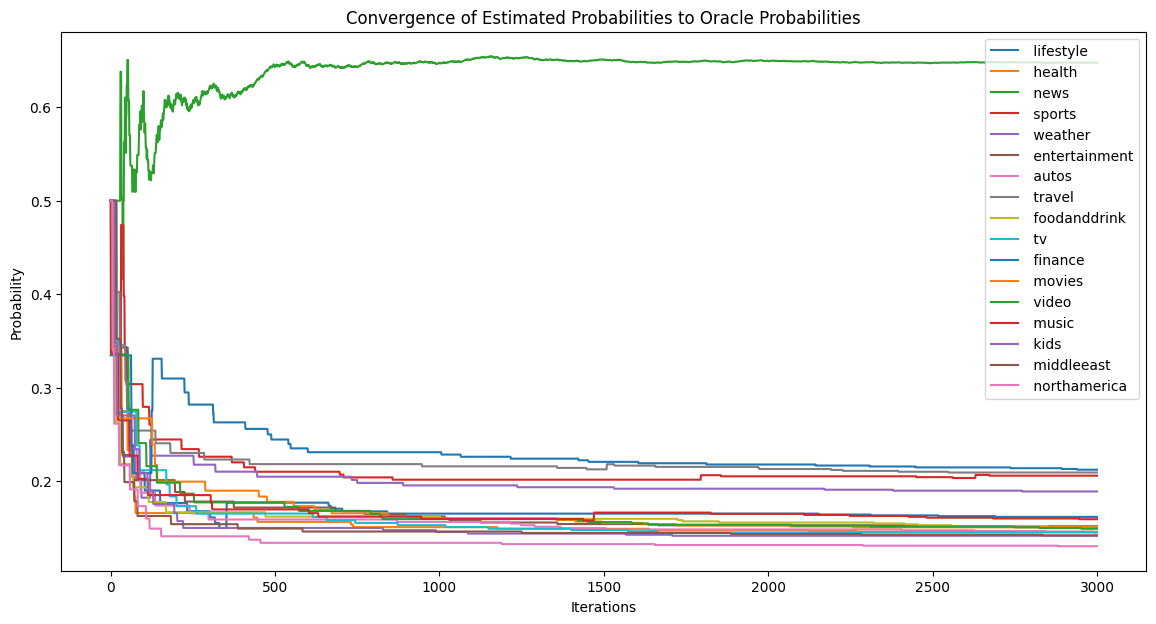

In [ ]:
plt.figure(figsize=(14, 7))

for category in categories:
    plt.plot(probability_history[category], label=f' {category}')


plt.title('Convergence of Estimated Probabilities to Oracle Probabilities')
plt.xlabel('Iterations')
plt.ylabel('Probability')
plt.legend()
plt.show()
